# **Deskriptive Statistik**
___
## Inhalt
1. [Übersicht](#übersicht)
   1. [Sensoren](#sensoren)
   2. [Fehlende Daten](#fehlende-daten)
2. [Anwesenheit](#anwesenheit)

3. [Raumklima](#raumklima)
4. [Thermischer Komfort](#thermischer-komfort)
5. [Heizung](#heizung)
6. [Fenster](#fensteröffnung)

## Importe

In [1]:
### Jupyter Einstellungen

%load_ext autoreload
%autoreload 2

### Python Pakete

import locale
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')
import datetime as dt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
from pandas import IndexSlice as IDX

import src.preprocessing as pp
import src.toolbox as tb
import src.style as style
from src.style import BUID, ROOMS, APPS, SENSORS, cleanBuiAppAxis, datemapaxis

### Datenbank Import

try:
    from src.preprocessing import DB, AMB, getData
except ImportError:
    pp.getDB()
    from src.preprocessing import DB, AMB, getData
DB.head(2)

Lade WetterDB...
Lade Raumklima...
Lade gespeicherte Datenbank...                                                                


bui                          LB                                           \
app                           N                                            
room                          B                                            
value                     HK_IO  Rh Rh_amb T_amb T_amb_g24 Tair Thk Tset   
Datetime                                                                   
2021-02-08 11:00:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:01:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   

bui                                      ...  MW                              \
app                                      ...   S                               
room                                  K  ...  WZ                               
value                     g_abs Fenster  ...  Rh Rh_amb T_amb T_amb_g24 Tair   
Datetime                                 ...                                   
2021-02-08 11:00:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:01:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   

bui                                               
app                                               
room                                              
value                     Thk Top Tset Tsk g_abs  
Datetime                                          
2021-02-08 11:00:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:01:00+01:00 NaN NaN  NaN NaN   NaN  

[2 rows x 408 columns]

# **Übersicht**

## Sensoren

- Unterscheidung in Sensoren und ermittelte Datensätze

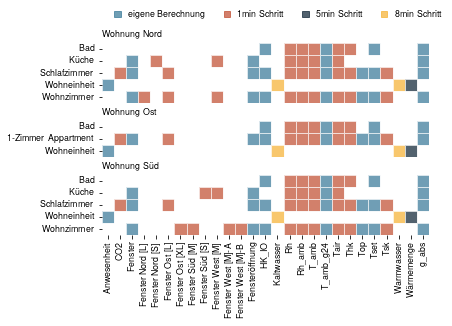

In [2]:
mapper = pd.DataFrame([style.sensortypes, style.sensorkind]).T.set_axis(['kind', 'type'], axis=1)
df = pd.concat([pd.Series({tuple(item.split('_')): sensor for item in location}) for sensor, location in style.sensor_locations.items()])
df = df.rename_axis(['app', 'room']).rename('sensor').reset_index().assign(count = 1).pivot_table(columns=['app', 'room'], index='sensor', values='count', aggfunc=np.sum)
df = pd.concat({col: mapper.type.where(data.notna()) for col, data in df.iteritems()}, axis=1).T.infer_objects().dropna(how='all', axis=1)
norm = mpl.colors.BoundaryNorm([-0.5,0.5,1.5,6,9], ncolors=4)
cmap = mpl.colors.ListedColormap(['#407e9c','#c3553a',"#182d3e","#F6B53C"])
fig, axs = plt.subplots(3,1, sharex=True)
for i, (app, _data) in enumerate(df.groupby(level=0, axis=0)):
    sns.heatmap(data=_data.droplevel(0).rename(index=style.NAMES), cmap=cmap, norm=norm, linewidths=.5, square=True, cbar=False, ax=axs[i], alpha=0.75)
    axs[i].set_title(f'Wohnung {APPS[app]}')
    axs[i].set_ylabel(None)
    axs[i].set_xlabel(None)
    if i < 2:
        axs[i].xaxis.set_visible(False)
plt.subplots_adjust(hspace=0.01, wspace=0.01)
fig.legend([mpl.patches.Patch(color=cmap(i), alpha=0.75) for i in range(4)], ['eigene Berechnung', '1min Schritt', '5min Schritt', '8min Schritt'], bbox_to_anchor=(.95,1.025),loc = 'upper right', handlelength=0.7, ncol=4)

## Fehlende Daten

In [3]:
sensors = DB.loc[:,DB.columns.get_level_values(3).isin(SENSORS[SENSORS == 'SENSOR_1min'].drop(['Tsk', 'global', 'windspeed']).index.to_list())]
pct_missing = pp.removeUnoccupied(sensors.isna()).sum().div(pp.removeUnoccupied(sensors.fillna(0)).notna().count())

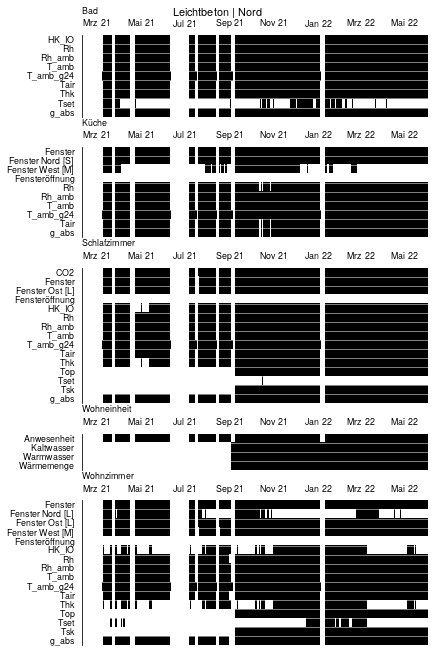

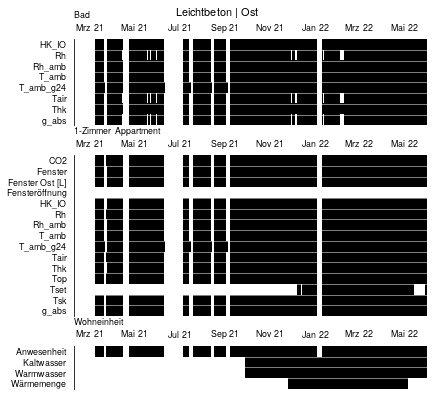

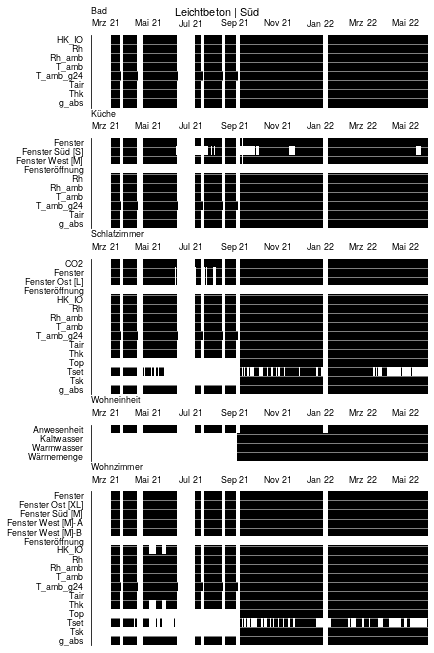

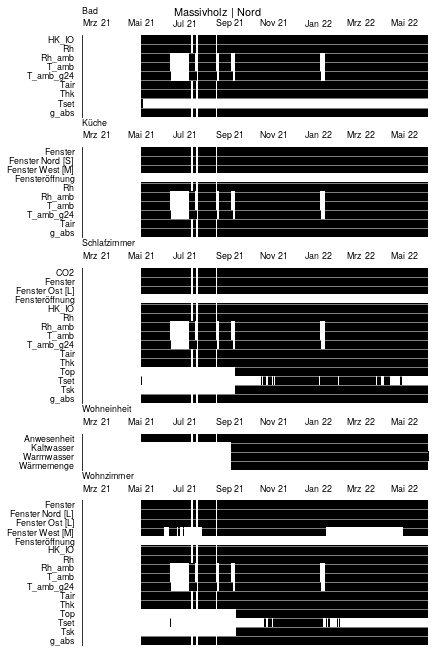

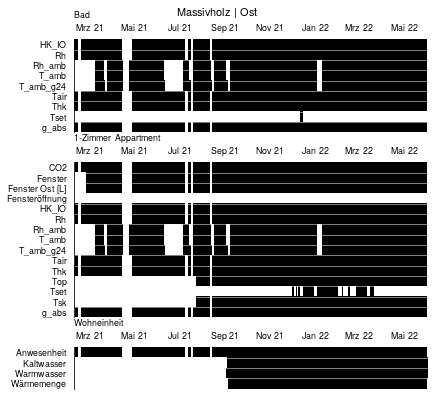

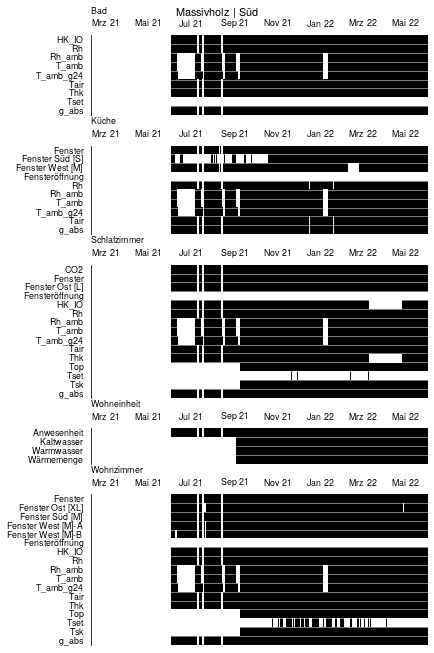

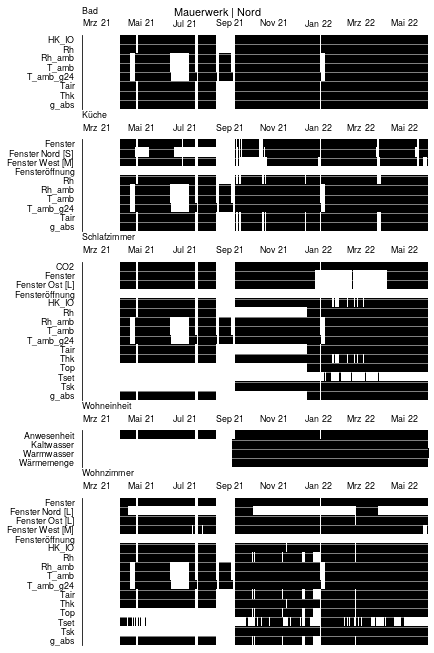

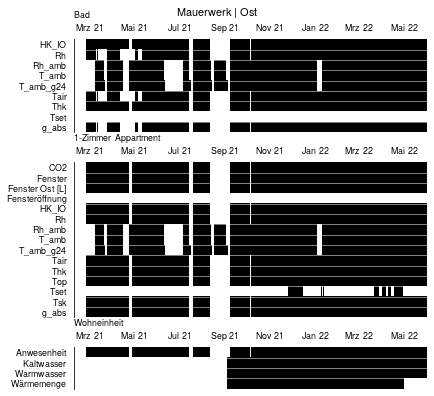

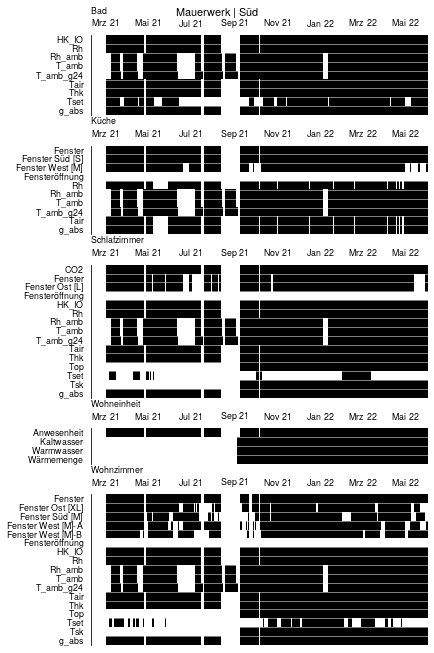

In [4]:
cmap = mpl.colors.ListedColormap(["w", "k"])
by = 'room'
for (bui, app), data in DB.groupby(level=[0,1], axis=1):
    rows = len(data[bui, app].columns.get_level_values(by).unique())
    fig, axs = plt.subplots(rows,1, **style.size(subplots=[rows/2, 1]), gridspec_kw={'height_ratios':data[bui, app].groupby(level=by, axis=1).size().to_list()})
    fig.suptitle(f'{BUID[bui]} | {APPS[app]}')
    for r, (room, group) in enumerate(data[bui, app].groupby(level=by, axis=1)):
        pp.plotMissingData(group, ax= axs[r], level=1, title=f'{style.NAMES[room]}', cmap=cmap)
    fig.tight_layout(pad=0.1)

## Übersichtstabelle

In [5]:
df = DB.resample('D').mean().notna().groupby(['bui', 'app'], axis=1).median().replace(0, np.NaN).apply(lambda s: {'Beobachtungsbeginn': s.first_valid_index().strftime('%d.%m.%Y'), 'Beobachtungsende': s.last_valid_index().strftime('%d.%m.%Y'), 'Beobachtungsdauer': (s.last_valid_index()-s.first_valid_index()).days}, result_type='expand').T
df = df.join(
    #pct_missing.groupby(level=[0,1]).mean().mul(100).round(1).rename('Anteil fehlend')
    pp.removeUnoccupied(DB.resample('D').mean().notna().groupby(['bui', 'app'], axis=1).median()).eq(0).sum().rename('Tage ohne Daten')
)

(df
.rename(index=style.NAMES).rename(index=style.NAMES).rename_axis(['Haus', 'Wohnung'])
.style
.format(formatter={'Anteil fehlend': r"{:.1f} \si{{\percent}}"})
)

# **Anwesenheit**
__

[Zurück zum Anfang](#importe)

## Clustering

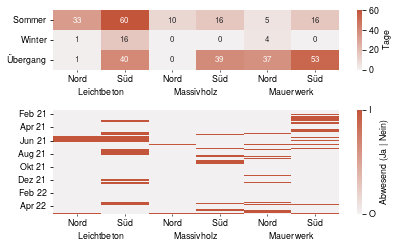

In [6]:
sig = pp.removeHolidays('filter').resample('D').mean().sort_index(axis=1)
fig, axs = plt.subplots(2,1, **style.size(aspect=.6), gridspec_kw=dict(height_ratios=[1,1.75]))
df = sig.groupby(lambda s: tb.utils.getSeason(s.month)).sum().round()
ax = sns.heatmap(ax=axs[0], data=df, vmin=0, cmap=style.Reds, annot=True, fmt='2.2n',annot_kws={"size":8}, cbar_kws={'label': 'Tage', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
ax = sns.heatmap(data=sig, cmap=style.Reds, cbar_kws=dict(ticks=[0,1], label='Abwesend (Ja | Nein)'))
tb.utils.set_date_ticks(ax, sig.index.min().date(), sig.index.max().date(), freq='2M', date_format='%b %y')
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(['O','I'])
cleanBuiAppAxis(ax, 'x')
ax.set(title=None, ylabel=None, xlabel=None)
fig.tight_layout()

## Auswertung

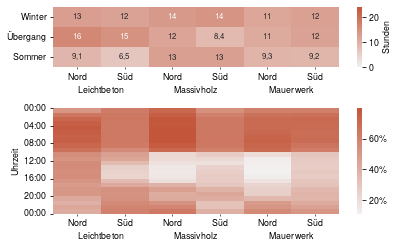

In [7]:
data = getData(app=['N', 'S'], value='Anwesenheit')
fig, axs = plt.subplots(2,1, **style.size(aspect=.6), gridspec_kw=dict(height_ratios=[1,1.75]))
df = data.gt(0).groupby(level=[0,1], axis=1).max().resample('D').sum().div(60)
df = df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(ax=axs[0], data=df, vmin=0, vmax=1440/60, cmap=style.Reds, annot=True, fmt='2.2n',annot_kws={"size":8}, cbar_kws={'label': 'Stunden', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
df = data.gt(0).groupby(level=[0,1], axis=1).max().groupby(lambda x: x.hour).mean()
ax = sns.heatmap(data=df, ax=axs[1], cmap=style.Reds)
ax.set(title=None, ylabel=None, xlabel=None)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, 0, symbol='%'))
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

# **Raumklima**
___
[Zurück zum Anfang](#importe)

## Lufttemperatur

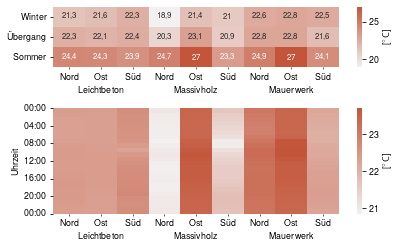

In [8]:
data = DB.loc[:,IDX[:,['N','O', 'S'],:,'Tair']].groupby(level=[0,1], axis=1).median()

df = data.resample('D').mean()
fig, axs = plt.subplots(2,1, **style.size(aspect=0.6), gridspec_kw=dict(height_ratios=[1,1.75]))
ax = sns.heatmap(ax=axs[0], data=df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']), cmap=style.Reds, annot=True, fmt='.3n',annot_kws={"size":8},cbar_kws={'label': r'$[\si{\celsius}]$', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')

df = data
ax = sns.heatmap(ax=axs[1], data=df.groupby(df.index.hour).mean(), cmap=style.Reds, cbar_kws={'label': r'$[\si{\celsius}]$'} )
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

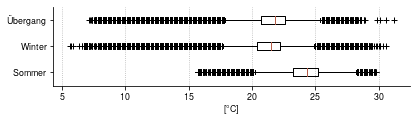

In [9]:
df = getData(value='Tair', app=['N', 'S'], room=['WZ', 'SZ', 'K']).stack(['bui', 'app', 'room']).assign(Season=lambda x: tb.utils.getSeason(x.index))
x = {season: group['Tair'].dropna().reset_index(drop=True) for season, group in df.groupby('Season')}
fig, ax = plt.subplots(**style.size(.3))
ax.boxplot(x = x.values(), labels=x.keys(), sym='+', vert=False)
ax.set(xlabel=r'[\si{\celsius}]')
ax.grid(axis='x')
fig.tight_layout()

## operative Raumtemperatur

In [10]:
TOP = pp.estimateOperativeTemperature(mode='pred').loc[:,IDX[:,['N', 'O', 'S'],:,:]]
TOP.head()

bui                        LB                                      ...  MW  \
app                         N               O       S              ...   N   
room                        B   K  SZ  WZ   B SWK   B   K  SZ  WZ  ...   B   
value                     Top Top Top Top Top Top Top Top Top Top  ... Top   
Datetime                                                           ...       
2021-02-08 11:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
2021-02-08 12:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
2021-02-08 13:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
2021-02-08 14:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
2021-02-08 15:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   

bui                                                            
app                                     O       S              
room                        K  SZ  WZ   B SWK   B   K  SZ  WZ  
value                     Top Top Top Top Top Top Top Top Top  
Datetime                                                       
2021-02-08 11:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-02-08 12:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-02-08 13:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-02-08 14:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-02-08 15:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 30 columns]

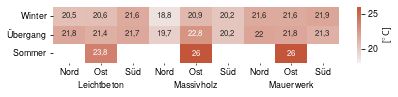

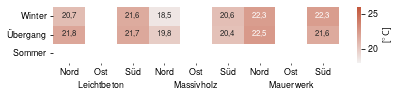

In [11]:
data = DB.loc[:,IDX[:,['N','O', 'S'],:,'Top']].groupby(level=[0,1], axis=1).median()

kws = dict(cmap=style.Reds, annot=True, fmt='.3n',annot_kws={"size":8}, vmin=18, vmax=26, cbar_kws=dict(label=r'[$\si{\celsius}$]', aspect=12))

top_messung = data.resample('D').mean()
top_messung = top_messung.groupby(tb.utils.getSeason(top_messung.index)).mean().where(top_messung.groupby(tb.utils.getSeason(top_messung.index)).count() > 7).reindex(['Winter', 'Übergang', 'Sommer'])

fig, axs = plt.subplots(**style.size(aspect=0.25))
ax = sns.heatmap(data=top_messung, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

df = TOP.loc[data.loc[:,IDX[:,['N','S']]].resample('H').mean().dropna(how='all').index,:].groupby(level=[0,1], axis=1).median().resample('D').mean()
df = df.groupby(tb.utils.getSeason(df.index)).mean().where(df.groupby(tb.utils.getSeason(df.index)).count() > 7).reindex(['Winter', 'Übergang', 'Sommer'])
df.loc[:,IDX[:,'O']] = np.NaN
fig, ax = plt.subplots(1,1, **style.size(aspect=.25))
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

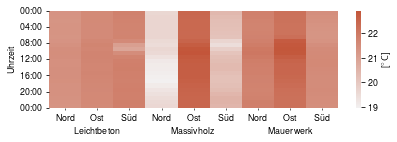

In [12]:
df = data
fig, ax = plt.subplots(**style.size(aspect=0.35))
ax = sns.heatmap(data=df.groupby(df.index.hour).mean(), cmap=style.Reds, ax = ax, cbar_kws={'label': r'[$\si{\celsius}$]'} )
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

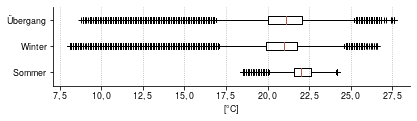

In [13]:
df = getData(value='Top', app=['N', 'S'], room=['WZ', 'SZ', 'K']).stack(['bui', 'app', 'room']).assign(Season=lambda x: tb.utils.getSeason(x.index))
x = {season: group['Top'].dropna().reset_index(drop=True) for season, group in df.groupby('Season')}
fig, ax = plt.subplots(**style.size(.3))
ax.boxplot(x = x.values(), labels=x.keys(), sym='+', vert=False)
ax.set(xlabel=r'[\si{\celsius}]')
ax.grid(axis='x')
fig.tight_layout()

## Luftfeuchte

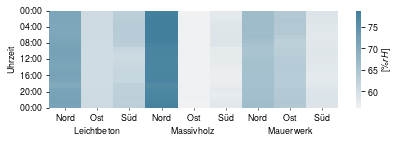

In [14]:
data = getData(value='Rh').groupby(level=[0,1], axis=1).max()
fig = plt.figure(**style.size(aspect=0.35))
ax = sns.heatmap(data=data.groupby(data.index.hour).median(), cmap=style.Blues, cbar_kws={'label': r'[$\si{\percent} rH$]', 'format': '%.0f%%'} )
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

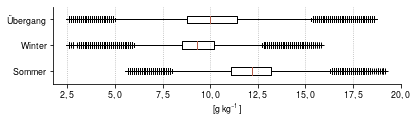

In [15]:
df = getData(value='g_abs', app=['N', 'S'], room=['WZ', 'SZ', 'K']).stack(['bui', 'app', 'room']).assign(Season=lambda x: tb.utils.getSeason(x.index))
x = {season: group['g_abs'].dropna().reset_index(drop=True) for season, group in df.groupby('Season')}
fig, ax = plt.subplots(**style.size(.3))
ax.boxplot(x = x.values(), labels=x.keys(), sym='+', vert=False)
ax.set(xlabel=r'[\si{\gram\per\kilogram}]')
ax.grid(axis='x')
fig.tight_layout()

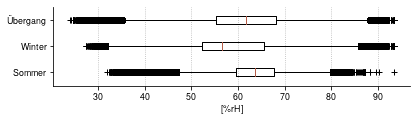

In [16]:
df = getData(value='Rh', app=['N', 'S'], room=['WZ', 'SZ', 'K']).stack(['bui', 'app', 'room']).assign(Season=lambda x: tb.utils.getSeason(x.index))
x = {season: group['Rh'].dropna().reset_index(drop=True) for season, group in df.groupby('Season')}
fig, ax = plt.subplots(**style.size(.3))
ax.boxplot(x = x.values(), labels=x.keys(), sym='+', vert=False)
ax.set(xlabel=r'[\si{\percent rH}]')
ax.grid(axis='x')
fig.tight_layout()

In [17]:
rh_raw = pd.concat({(bui, app): pp.getCleanTRHdata(bui, app, sensortype='Rh', correction=False).max(axis=1) for bui in BUID for app in APPS}, axis=1)
g_raw = pd.concat({(bui, app): tb.comf.g_abs(pp.getCleanTRHdata(bui, app, sensortype='Tair', correction=False).droplevel(1, axis=1), pp.getCleanTRHdata(bui, app, sensortype='Rh', correction=False).droplevel(1,axis=1)).max(axis=1) for bui in BUID for app in APPS}, axis=1)

rh_lin = pd.concat({(bui, app): pp.getCleanTRHdata(bui, app, sensortype='Rh', correction='lin').max(axis=1) for bui in BUID for app in APPS}, axis=1)
g_lin = pd.concat({(bui, app): tb.comf.g_abs(pp.getCleanTRHdata(bui, app, sensortype='Tair', correction=False).droplevel(1, axis=1), pp.getCleanTRHdata(bui, app, sensortype='Rh', correction='lin').droplevel(1,axis=1)).max(axis=1) for bui in BUID for app in APPS}, axis=1)

rh_fix = pd.concat({(bui, app): pp.getCleanTRHdata(bui, app, sensortype='Rh', correction='fix').max(axis=1) for bui in BUID for app in APPS}, axis=1)
g_fix = pd.concat({(bui, app): tb.comf.g_abs(pp.getCleanTRHdata(bui, app, sensortype='Tair', correction=False).droplevel(1, axis=1), pp.getCleanTRHdata(bui, app, sensortype='Rh', correction='fix').droplevel(1,axis=1)).max(axis=1) for bui in BUID for app in APPS}, axis=1)

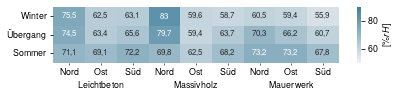

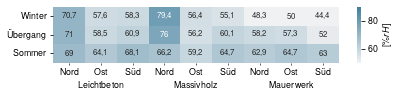

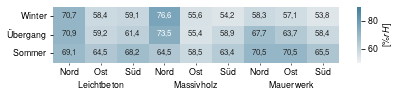

In [18]:
kws = dict(cmap=style.Blues, annot=True, fmt='.3n',annot_kws={"size":8}, vmin=50, vmax=90, cbar_kws=dict(label=r'$[\si{\percent} rH]$', aspect=12))

# rH ohne Korrektur
fig, ax = plt.subplots(**style.size(aspect=0.25))
df = rh_raw.resample('D').mean()    # Tagesmiitel
df = df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']) 
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

# rH mit statischer Korrektur
fig, ax = plt.subplots(**style.size(aspect=0.25))
df = rh_fix.resample('D').mean()
df = df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

#rH mit linearer Korrektur
fig, ax = plt.subplots(**style.size(aspect=0.25))
df = rh_lin.resample('D').mean()
df = df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

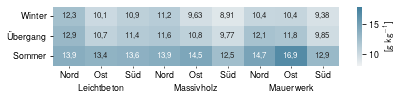

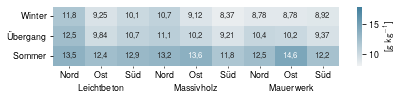

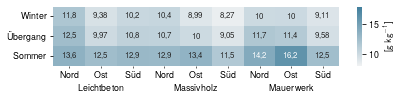

In [19]:
kws = dict(cmap=style.Blues, annot=True, fmt='.3n',annot_kws={"size":8}, vmin=8, vmax=18, cbar_kws=dict(label=r'$[\si{\gram\per\kilogram}]$', aspect=12))

# g ohne Korrektur
fig, ax = plt.subplots(**style.size(aspect=0.25))
df = g_raw.resample('D').mean()
df = df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

# g mit statischer Korrektur
fig, ax = plt.subplots(**style.size(aspect=0.25))
df = g_fix.resample('D').mean()
df = df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax)
fig.tight_layout()

# g mit linearer Korrektur
fig, ax = plt.subplots(**style.size(aspect=0.25))
df = g_lin.resample('D').mean()
df = df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(data=df,ax=ax, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax)
fig.tight_layout()

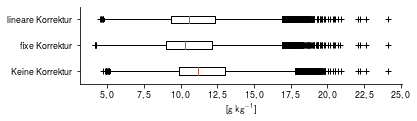

In [20]:
fig, ax = plt.subplots(**style.size(.3))
ax.boxplot([g_raw.resample('H').mean().stack([0,1]), g_fix.resample('H').mean().stack([0,1]), g_lin.resample('H').mean().stack([0,1])], labels=['Keine Korrektur', 'fixe Korrektur', 'lineare Korrektur'], sym='+', vert=False)
ax.set(xlabel=r'[$\si{\gram\per\kilogram}$]')
fig.tight_layout()

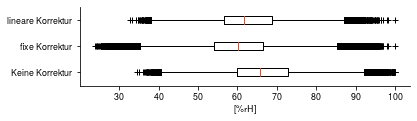

In [21]:
fig, ax = plt.subplots(**style.size(.3))
ax.boxplot([rh_raw.resample('H').mean().stack([0,1]), rh_fix.resample('H').mean().stack([0,1]), rh_lin.resample('H').mean().stack([0,1])], labels=['Keine Korrektur', 'fixe Korrektur', 'lineare Korrektur'], sym='+', vert=False)
ax.set(xlabel=r'[$\si{\percent rH}$]')
fig.tight_layout()

Timestep is <Minute>. Resampling to Hour...
Timestep is <Minute>. Resampling to Hour...


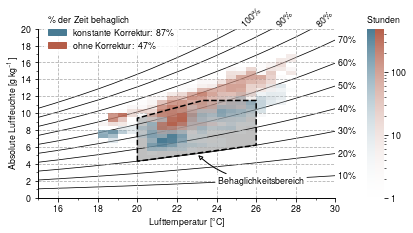

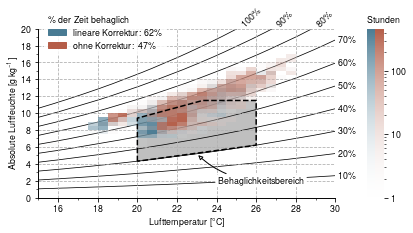

In [22]:
app = 'N'
room = 'SZ'
mapper = {'fix': 'konstante', 'lin': 'lineare'}
bui = 'MW'
for correction in ['fix', 'lin']:
    _temp = pd.concat([pp.getCleanTRHdata(bui, app, sensortype='Tair', correction=correction)[room].squeeze().rename(f'{mapper[correction]} Korrektur'), pp.getCleanTRHdata(bui, app, sensortype='Tair', correction=False)[room].squeeze().rename('ohne Korrektur')], axis=1)
    _rh = pd.concat([pp.getCleanTRHdata(bui, app, sensortype='Rh', correction=correction)[room].squeeze().rename(f'{mapper[correction]} Korrektur'), pp.getCleanTRHdata(bui, app, sensortype='Rh', correction=False)[room].squeeze().rename('ohne Korrektur')], axis=1)
    hx = tb.comf.hxdiagramm(_temp, _rh, kind='hist', cmap=[style.red,style.blue], **style.size(aspect=.5))
    hx.set_title(f'{BUID[bui]} | {APPS[app]} | {ROOMS[room]}', fig=False, title=False)

## CO $_2$ Konzentration

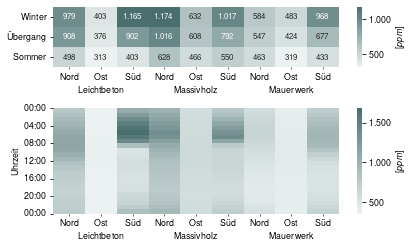

In [23]:
data = DB.loc[:,IDX[:,['N', 'O', 'S'],:,'CO2']].groupby(level=[0,1], axis=1).max()

fig, axs = plt.subplots(2,1, **style.size(aspect=0.6), gridspec_kw=dict(height_ratios=[1,1.75]))
df = data.resample('D').mean()
df = df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']).round(0)
ax = sns.heatmap(ax=axs[0], data=df, cmap=style.Greens, annot=True, fmt='.4n',annot_kws={"size":8},cbar_kws={'label': r'$[ppm]$', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
df = DB.loc[:,IDX[:,['N', 'O', 'S'],:,'CO2']].groupby(level=[0,1], axis=1).max()
ax = sns.heatmap(ax=axs[1], data=df.groupby(df.index.hour).mean(), cmap=style.Greens, fmt='.4n',annot_kws={"size":8},cbar_kws={'label': r'$[ppm]$'})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

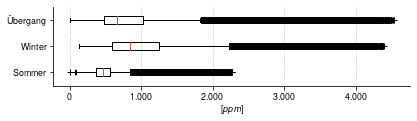

In [24]:
df = getData(value='CO2', app=['N', 'S'], room=['WZ', 'SZ', 'K']).stack(['bui', 'app', 'room']).assign(Season=lambda x: tb.utils.getSeason(x.index))
x = {season: group['CO2'].dropna().reset_index(drop=True) for season, group in df.groupby('Season')}
fig, ax = plt.subplots(**style.size(.3))
ax.boxplot(x = x.values(), labels=x.keys(), vert=False, sym='+')
ax.set(xlabel=r'$[ppm]$')
ax.grid(axis='x')
fig.tight_layout()

# Wetter
___
[Zurück zum Anfang](#importe)

In [25]:
from geopy import geocoders
from meteostat import Stations, Hourly
from timezonefinder import TimezoneFinder

location = 'Mietraching'

loc = geocoders.Nominatim(user_agent="RamonsRobusteThesis").geocode(location)
station = Stations().nearby(loc.latitude, loc.longitude).fetch(1)
timezone = TimezoneFinder().timezone_at(lng=loc.longitude, lat=loc.latitude)
start = AMB.resample('D').mean().index.min().tz_convert('utc').to_pydatetime().replace(tzinfo=None)
ende = AMB.resample('D').mean().index.max().tz_convert('utc').to_pydatetime().replace(tzinfo=None)
refdata = Hourly(station, start, ende).fetch().tz_localize('utc').tz_convert(timezone)
refdata

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2021-03-08 00:00:00+01:00,3.1,1.8,91.0,0.1,NaN,251.0,7.6,NaN,1020.6,0.0,NaN
2021-03-08 01:00:00+01:00,2.7,2.0,95.0,0.0,NaN,265.0,9.0,NaN,1020.8,0.0,NaN
2021-03-08 02:00:00+01:00,2.6,1.9,95.0,0.0,NaN,271.0,6.8,NaN,1020.9,0.0,NaN
2021-03-08 03:00:00+01:00,2.6,1.9,95.0,0.0,NaN,280.0,4.7,NaN,1020.6,0.0,NaN
2021-03-08 04:00:00+01:00,2.5,1.8,95.0,0.0,NaN,278.0,6.5,NaN,1020.4,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00+02:00,15.6,12.9,84.0,0.1,NaN,193.0,9.0,NaN,1016.7,0.0,NaN
2022-06-01 21:00:00+02:00,15.2,13.2,88.0,0.3,NaN,195.0,7.9,NaN,1016.8,0.0,NaN
2022-06-01 22:00:00+02:00,14.7,13.6,93.0,0.0,NaN,196.0,9.0,NaN,1017.2,0.0,NaN


## Außenlufttemperatur

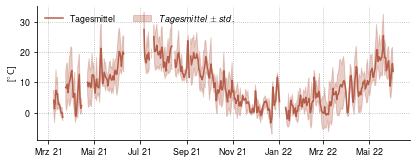

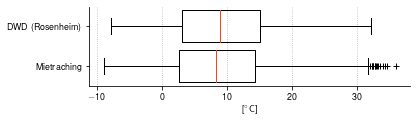

In [26]:
mean, std = AMB['T_amb'].resample('D').mean(), AMB['T_amb'].resample('D').std()
lower, upper = mean - std, mean + std
x = mean.index

fig, ax = plt.subplots(**style.size(aspect=0.4))
ax.plot(mean, c=style.CMAP[1], label=r'Tagesmittel')
ax.fill_between(x, lower, upper, alpha=0.3, color=style.CMAP[1], label=r'$Tagesmittel \pm std.$')
ax.set_ylabel(r'$[\si{\celsius}]$')
#ax.set_title('Außenlufttemperatur $T_{amb}$')
ax.grid(axis='both', ls = 'dotted')
ax.legend(loc='upper left', ncol=2)
fig.tight_layout()

fig, ax = plt.subplots(**style.size(aspect=0.3))
ax.boxplot([AMB['T_amb'].resample('H').mean().dropna(), refdata['temp'].dropna()], sym='+', medianprops={'color':style.CMAP[1]}, widths=[0.8, 0.8], vert=False)
#ax.set_title('Vergleich mit der nächsen DWD-Station')
ax.set_xlabel(r'$[\si{\celsius}]$')
ax.set_yticks([1, 2], ['Mietraching', 'DWD (Rosenheim)'], rotation = 0)
ax.grid(axis='x', ls = 'dotted')
fig.tight_layout()

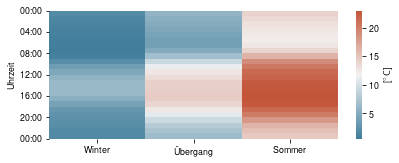

In [27]:
fig, ax = plt.subplots(**style.size(aspect=0.4))
ax = sns.heatmap(pd.concat([group.groupby(group.index.hour).mean().rename(season) for season, group in AMB.T_amb.groupby(tb.utils.getSeason(AMB.index))], axis=1)[['Winter', 'Übergang', 'Sommer']], cmap=style.HEATMAP, cbar_kws={'label': r'[$\si{\celsius}$]'})
ax.set(ylabel=None, xlabel=None)
datemapaxis(ax)
fig.tight_layout()

In [28]:
df = AMB.T_amb.groupby(tb.utils.getSeason(AMB.index)).agg(['min', 'max', 'mean', 'median', 'std']).reindex(['Winter', 'Übergang', 'Sommer']).rename_axis('Jahreszeit')
(df.style
.format(formatter='{:.1f} °C', escape='latex')
.format(formatter='{:.1f} K', escape='latex', subset=['std'])
)

,min,max,mean,median,std
Jahreszeit,,,,,
Winter,-8.8 °C,16.9 °C,2.8 °C,2.4 °C,4.3 K
Übergang,-9.2 °C,37.2 °C,9.0 °C,8.5 °C,7.3 K
Sommer,2.3 °C,34.6 °C,17.7 °C,16.2 °C,5.6 K


## Globalstrahlung

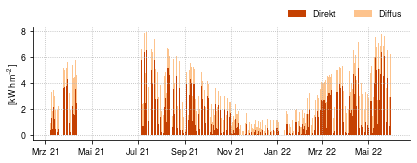

In [29]:
fig, ax = plt.subplots(**style.size(aspect=0.4))
ax.set_ylabel(r'[\si{\kilo\watt\hour\per\square\metre}]')
df_p = AMB[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000
ax.bar(df_p.index, df_p['direct'], bottom = 0, color=plt.cm.Oranges(0.8), label = 'Direkt', alpha=1)
ax.bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Oranges(0.3), label = 'Diffus', alpha=1)
ax.grid(axis='both', ls = 'dotted')
#ax.tick_params(labelleft=True, labelright=True, left=True, right=True)
ax.legend(loc='lower right',ncol=99,bbox_to_anchor=(1,1),frameon=False)  
fig.tight_layout()

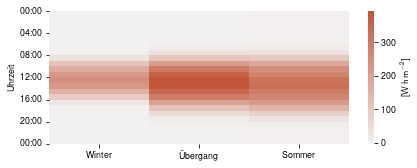

In [30]:
df = AMB[['direct','diffuse']].resample('H').mean().sum(axis=1).rename('global').to_frame().assign(Season=lambda df: tb.utils.getSeason(df.index)).pivot(columns='Season').droplevel(0,1).reindex(['Winter', 'Übergang', 'Sommer'], axis=1)
fig, ax = plt.subplots(**style.size(aspect=0.4))
ax = sns.heatmap(data=df.groupby(df.index.hour).mean(), cmap=style.Reds, cbar_kws={'label':r'$[\si{\watt\hour\per\square\meter}]$'})
ax.set(ylabel='Uhrzeit', xlabel=None)
fig.tight_layout()
datemapaxis(ax)

## relative Außenluftfeuchte

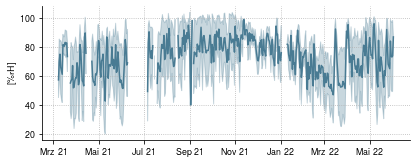

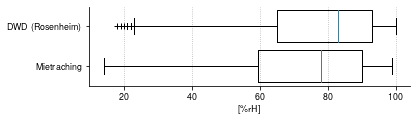

In [31]:
mean, std = AMB['Rh_amb'].resample('D').mean(), AMB['Rh_amb'].resample('D').std()
lower, upper = mean - std, mean + std
x = mean.index

fig, ax = plt.subplots(**style.size(aspect=0.4))
ax.plot(mean, c=style.CMAP[0])
ax.fill_between(x, lower, upper, alpha=0.3, color=style.CMAP[0])
ax.set_ylabel(r'$[\si{\percent rH}]$')
#ax.set_title('rel. Außenluftfeuchte')
ax.grid(axis='both')
fig.tight_layout()

fig, ax = plt.subplots(**style.size(aspect=0.3))
ax.boxplot([AMB['Rh_amb'].resample('H').mean().dropna(), refdata['rhum']], sym='+', widths = [0.8, 0.8], medianprops={'color':style.CMAP[0]}, vert=False)
#ax.set_title('Vergleich mit der nächsen DWD-Station')
ax.set_xlabel(r'$[\si{\percent rH}]$')
ax.set_yticks([1, 2], ['Mietraching', 'DWD (Rosenheim)'])
ax.grid(axis='x')
fig.tight_layout()

# Heizung
___
[Zurück zum Anfang](#importe)

## Zusammenfassung Heiztage

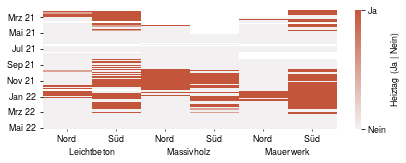

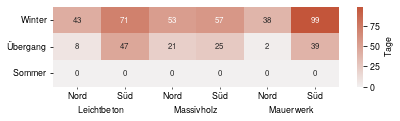

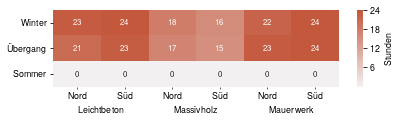

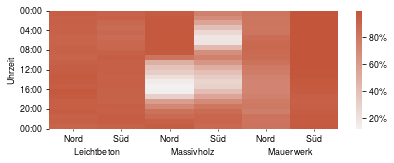

In [32]:
Heiztage = pp.getHeiztage()

fig, ax = plt.subplots(**style.size(aspect=0.4))
df = Heiztage.resample('D').mean().groupby(level=[0,1], axis=1).median()
ax = sns.heatmap(data=df, cmap=style.Reds, cbar_kws=dict(ticks=[0,1], label='Heiztag (Ja | Nein)'))
tb.utils.set_date_ticks(ax, df.index.min().date(), df.index.max().date(), freq='2M', date_format='%b %y')
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(['Nein','Ja'])
cleanBuiAppAxis(ax, 'x')
ax.set(title=None, ylabel=None, xlabel=None)
fig.tight_layout()

df = df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']).mul(100).round(0)
fig, ax = plt.subplots(**style.size(aspect=0.3))
ax = sns.heatmap(data=df, ax=ax, vmin=0, cmap=style.Reds, annot=True, fmt='2n',annot_kws={"size":8},cbar_kws={'aspect':12, 'label':'Tage'})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

data = getData(value='HK_IO', app=['N', 'S'])
fig, ax = plt.subplots(**style.size(aspect=0.3))
df = data.gt(0).groupby(level=[0,1], axis=1).max().resample('D').sum().where(Heiztage.resample('D').mean().groupby(level=[0,1], axis=1).median()==1).groupby(lambda x: tb.utils.getSeason(x.month)).mean().reindex(['Winter', 'Übergang', 'Sommer']).div(60).round(1).fillna(0)
ax = sns.heatmap(data=df, ax=ax, vmin=0, vmax=24, cmap=style.Reds, annot=True, fmt='.2n',annot_kws={"size":8},cbar_kws={'label': 'Stunden', 'ticks':[6,12,18,24], 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

df = data.where(Heiztage==1).groupby(level=[0,1], axis=1).max()
fig, ax = plt.subplots(**style.size(aspect=0.4))
ax = sns.heatmap(data=df.groupby(df.index.hour).mean(), cmap=style.Reds, ax=ax)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, 0, symbol='%'))
ax.set(title=None, ylabel='Uhrzeit', xlabel=None)
datemapaxis(ax)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

## Zusammenfassung ohne berücksichtigung der Heiztage

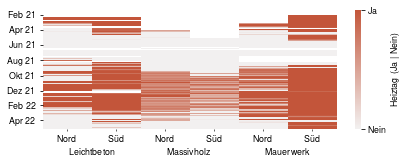

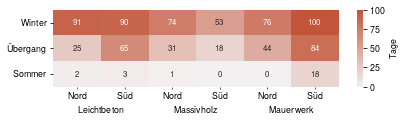

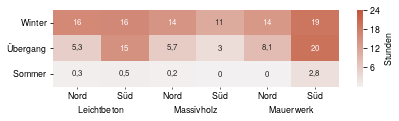

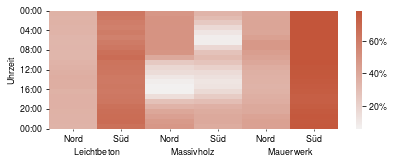

In [33]:
data = getData(value='HK_IO', app=['N', 'S'])

fig, ax = plt.subplots(**style.size(aspect=0.4))
df = data.resample('D').mean().groupby(level=[0,1], axis=1).max()
ax = sns.heatmap(data=df, cmap=style.Reds, cbar_kws=dict(ticks=[0,1], label='Heiztag (Ja | Nein)'))
tb.utils.set_date_ticks(ax, df.index.min().date(), df.index.max().date(), freq='2M', date_format='%b %y')
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(['Nein','Ja'])
cleanBuiAppAxis(ax, 'x')
ax.set(title=None, ylabel=None, xlabel=None)
fig.tight_layout()

df = df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']).mul(100).round(0)
fig, ax = plt.subplots(**style.size(aspect=0.3))
ax = sns.heatmap(data=df, ax=ax, vmin=0, cmap=style.Reds, annot=True, fmt='2n',annot_kws={"size":8},cbar_kws={'label': 'Tage', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

fig, ax = plt.subplots(**style.size(aspect=0.3))
df = data.gt(0).groupby(level=[0,1], axis=1).max().resample('D').sum().groupby(lambda x: tb.utils.getSeason(x.month)).mean().reindex(['Winter', 'Übergang', 'Sommer']).div(60).round(1).fillna(0)
ax = sns.heatmap(data=df, ax=ax, vmin=0, vmax=24, cmap=style.Reds, annot=True, fmt='.2n',annot_kws={"size":8},cbar_kws={'label': 'Stunden', 'ticks':[6,12,18,24], 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

fig, ax = plt.subplots(**style.size(aspect=0.4))
df = data.groupby(level=[0,1], axis=1).max()
ax = sns.heatmap(data=df.groupby(df.index.hour).mean(), cmap=style.Reds, ax=ax)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, 0, symbol='%'))
ax.set(title=None, ylabel='Uhrzeit', xlabel=None)
datemapaxis(ax)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

hkio = df.copy()

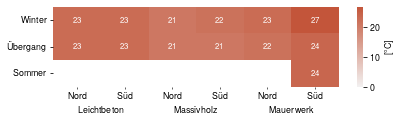

In [34]:
data = getData(value='Tset', app=['N', 'S'])
Heiztage = pp.getHeiztage()
df = data.droplevel(3, axis=1).where(Heiztage.droplevel(3, axis=1)).groupby(level=[0,1], axis=1).max().resample('D').median()
df = df.groupby(tb.utils.getSeason(df.index)).median().reindex(['Winter', 'Übergang', 'Sommer']).round(0)
fig, ax = plt.subplots(**style.size(aspect=0.3))
ax = sns.heatmap(data=df, ax=ax, vmin=0, cmap=style.Reds, annot=True, fmt='2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\celsius}]', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

## Ermittlung der Heizgrenztemperatur

In [35]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

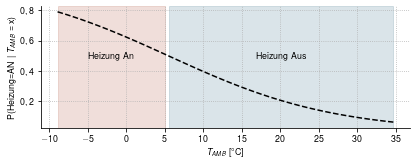

In [36]:
df = getData(value='HK_IO', app=['N', 'S']).resample('H').median().stack([0,1,2]).reset_index(['bui', 'app', 'room'], drop=True).merge(AMB['T_amb'].round(1), left_index=True, right_index=True, how='outer').dropna()

y = df['HK_IO'].astype('int')
X = df['T_amb'].astype('float').values.reshape(-1,1)

log_reg = LogisticRegressionCV(solver='liblinear', class_weight='balanced', scoring='roc_auc').fit(X, y)
X_pred = np.arange(X.min(), X.max(), 0.5)
y_pred = log_reg.predict(X_pred.reshape(-1,1))
x = np.linspace(X.min(), X.max(), 100)
y = log_reg.predict_proba(x.reshape(-1,1))[:,1]

fig, ax = plt.subplots(**style.size(aspect=0.4))
ax.plot(x,y, ls='dashed', color='k')
HK = pd.Series(y_pred, index=X_pred, name='HK').reset_index().groupby('HK').agg(['min', 'max']).droplevel(0, axis=1)
stat = {1: 'An', 0: 'Aus'}
for status, (_min, _max) in HK.iterrows():
    ax.axvspan(_min, _max, color=style.clrs[status], alpha=0.2)
    ax.text((_min+_max)/2, 0.5, f'Heizung {stat[status]}', va='center', ha='center')
ax.annotate(f"Grenzwert: {_max} \\si{{\\celsius}}", (_max, 0), xytext=(_max, 0.25), ha='center', va='center', arrowprops=dict(arrowstyle='-', connectionstyle="arc3,rad=-0.05",color="k", shrinkA=5, shrinkB=5))
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(steps=[1,5,10]))
ax.set_xlabel(r'$T_{AMB}$ [\si{\celsius}]')
ax.grid(axis='both')
ax.set_ylabel(r'P(Heizung=AN | $T_{AMB}$ = x)')
fig.tight_layout()

## Wärmeenergieverbrauch

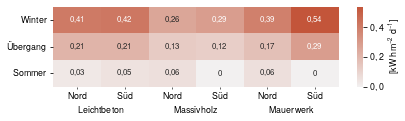

In [37]:
df = getData(value='Wärmemenge', app=['N', 'S']).droplevel(['room', 'value'], axis=1).dropna(how='all').diff().resample('D').sum().groupby(lambda s: tb.utils.getSeason(s.month)).mean().reindex(['Winter', 'Übergang', 'Sommer']).div(style.AREA, axis=1, level=1).dropna(axis=1)

fig, ax = plt.subplots(1,1, **style.size(aspect=0.3))
ax = sns.heatmap(data=df.round(2), ax = ax, cmap=style.Reds, annot=True, fmt='.2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\kilo\watt\hour\per\square\metre\per\day}]','aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

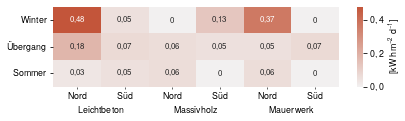

In [38]:
Heiztage = pp.getHeiztage()
df = getData(value='Wärmemenge', app=['N', 'S']).droplevel(['room', 'value'], axis=1).dropna(how='all').diff().resample('D').sum().where(Heiztage.astype(float).groupby(level=[0,1], axis=1).max().resample('D').median().eq(0)).groupby(lambda s: tb.utils.getSeason(s.month)).mean().reindex(['Winter', 'Übergang', 'Sommer']).div(style.AREA, axis=1, level=1).fillna(0)

fig, ax = plt.subplots(1,1, **style.size(aspect=0.3))
ax = sns.heatmap(data=df.round(2), ax = ax, cmap=style.Reds, annot=True, fmt='.2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\kilo\watt\hour\per\square\metre\per\day}]','aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

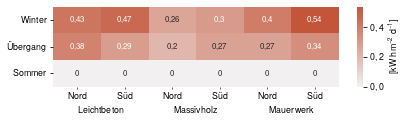

In [39]:
df = getData(value='Wärmemenge', app=['N', 'S']).droplevel(['room', 'value'], axis=1).dropna(how='all').diff().resample('D').sum().where(Heiztage.astype(float).groupby(level=[0,1], axis=1).max().resample('D').median().gt(0)).groupby(lambda s: tb.utils.getSeason(s.month)).mean().reindex(['Winter', 'Übergang', 'Sommer']).div(style.AREA, axis=1, level=1).fillna(0)

fig, ax = plt.subplots(1,1, **style.size(aspect=0.3))
ax = sns.heatmap(data=df.round(2), ax = ax, cmap=style.Reds, annot=True, fmt='.2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\kilo\watt\hour\per\square\metre\per\day}]','aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

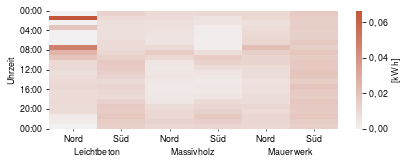

In [40]:
fig, ax = plt.subplots(1,1, **style.size(aspect=0.4))
df = getData(value='Wärmemenge', app=['N', 'S']).droplevel(['room', 'value'], axis=1).dropna(how='all').diff()
ax = sns.heatmap(data=df.groupby(df.index.hour).mean(), cmap=style.Reds, ax = ax, cbar_kws={'label': r'$[\si{\kilo\watt\hour}]$'} )
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

# **Thermischer Komfort**
___
[Zurück zum Anfang](#importe)

## adaptives Komfortmodell

In [41]:
KH = pp.getAdaptiveComfort(occupied=True)
KH.head()

bui                         LB                                                \
app                          N                   O                    S        
norm                        EN        NA        EN         NA        EN        
value                     UTGS ÜTGS UTGS ÜTGS UTGS ÜTGS  UTGS ÜTGS UTGS ÜTGS   
Datetime                                                                       
2021-03-08 11:00:00+01:00  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   
2021-03-08 12:00:00+01:00  NaN  NaN  NaN  NaN  NaN  NaN  0.05  NaN  NaN  NaN   
2021-03-08 13:00:00+01:00  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   
2021-03-08 14:00:00+01:00  NaN  NaN  NaN  NaN  NaN  NaN  0.30  NaN  NaN  NaN   
2021-03-08 15:00:00+01:00  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   

bui                        ...   MW                                          \
app                        ...    N         O                   S             
norm                       ...   NA        EN        NA        EN        NA   
value                      ... UTGS ÜTGS UTGS ÜTGS UTGS ÜTGS UTGS ÜTGS UTGS   
Datetime                   ...                                                
2021-03-08 11:00:00+01:00  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2021-03-08 12:00:00+01:00  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2021-03-08 13:00:00+01:00  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2021-03-08 14:00:00+01:00  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2021-03-08 15:00:00+01:00  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

bui                             
app                             
norm                            
value                     ÜTGS  
Datetime                        
2021-03-08 11:00:00+01:00  NaN  
2021-03-08 12:00:00+01:00  NaN  
2021-03-08 13:00:00+01:00  NaN  
2021-03-08 14:00:00+01:00  NaN  
2021-03-08 15:00:00+01:00  NaN  

[5 rows x 36 columns]

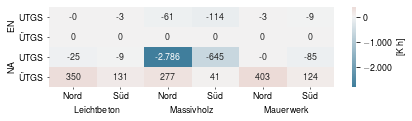

In [42]:
kh = KH.loc[:, IDX[:,['N','S'],:,:]].sort_index(axis=1).sum().round().unstack([2,3]).T
kh.loc[IDX[:,'UTGS'],:] *= -1
fig = plt.figure(**style.size(aspect=0.3))
ax = sns.heatmap(data=kh, cmap=style.HEATMAP, center=0, annot=True, fmt='4n', cbar_kws=dict(label=r'[\si{\kelvin\hour}]'))
cleanBuiAppAxis(ax)
cleanBuiAppAxis(ax, 'y')
ax.tick_params(axis='y', which='major', length=30)
fig.tight_layout()

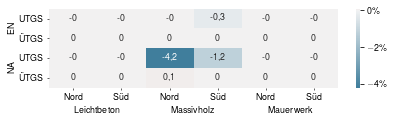

In [43]:
df = (pp.getOccupied(KH).sort_index(axis=1) > 2).sum().unstack([2,3]).div(pp.getHoursOccupied(app=['N','S']), axis=0).mul(100).dropna().T.round(1)
df.loc[IDX[:,'UTGS'],:] *= -1
fig = plt.figure(**style.size(aspect=0.3))
ax = sns.heatmap(data=df, cmap=style.HEATMAP,center=0, annot=True, fmt='1n')
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(100, 0, symbol='%'))
cleanBuiAppAxis(ax)
cleanBuiAppAxis(ax, 'y')
ax.tick_params(axis='y', which='major', length=30)
fig.tight_layout()

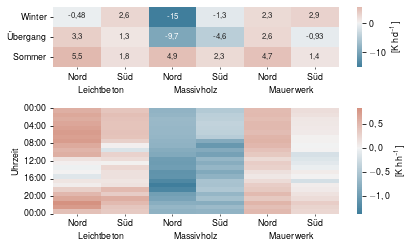

In [44]:
df = KH.loc[:,IDX[:,['N','S'],'NA','ÜTGS']].droplevel([2,3], axis=1).resample('D').sum(min_count=1).fillna(KH.loc[:,IDX[:,['N','S'],'NA','UTGS']].droplevel([2,3], axis=1).resample('D').sum(min_count=1).mul(-1))

fig, axs = plt.subplots(2,1, **style.size(aspect=0.6), gridspec_kw=dict(height_ratios=[1,1.75]))
ax = sns.heatmap(ax=axs[0], data=df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']), center=0, cmap=style.HEATMAP, annot=True, fmt='2.2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\kelvin\hour\per\day}]', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
df = KH.loc[:,IDX[:,['N','S'],'NA','ÜTGS']].droplevel([2,3], axis=1).fillna(KH.loc[:,IDX[:,['N','S'],'NA','UTGS']].droplevel([2,3], axis=1).mul(-1))
ax = sns.heatmap(ax=axs[1], data=df.groupby(df.index.hour).mean().fillna(0), cmap=style.HEATMAP, center=0, cbar_kws={'label': r'[\si{\kelvin\hour\per\hour}]'})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

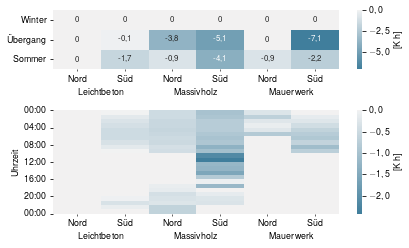

In [45]:
fig, axs = plt.subplots(2,1, **style.size(aspect=0.6), gridspec_kw=dict(height_ratios=[1,1.75]))
df = KH.loc[:,IDX[:,['N','S'],'EN','ÜTGS']].droplevel([2,3], axis=1).resample('D').sum(min_count=1).fillna(KH.loc[:,IDX[:,['N','S'],'EN','UTGS']].droplevel([2,3], axis=1).resample('D').sum(min_count=1).mul(-1))
ax = sns.heatmap(ax=axs[0], data=df.groupby(tb.utils.getSeason(df.index)).mean().round(1).fillna(0).reindex(['Winter', 'Übergang', 'Sommer']), center=0, cmap=style.HEATMAP, annot=True, fmt='2.2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\kelvin\hour}]', 'aspect': 12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
df = KH.loc[:,IDX[:,['N','S'],'EN','ÜTGS']].droplevel([2,3], axis=1).fillna(KH.loc[:,IDX[:,['N','S'],'EN','UTGS']].droplevel([2,3], axis=1).mul(-1))
ax = sns.heatmap(ax=axs[1], data=df.groupby(df.index.hour).mean().fillna(0), cmap=style.HEATMAP, center=0,cbar_kws={'label': r'[\si{\kelvin\hour}]'})
ax.set(title=None, ylabel='Uhrzeit', xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

## PMV/PPD

In [46]:
PMV, pmv_params = pp.calculatePMVPPD(update=True)
PMV.head()

Berechne PMV und PPD für Schlafzimmer und Wohnzimmer


bui                         LB                                           ...  \
app                          N                                           ...   
room                        SZ                                           ...   
value                     Tair Top  Rh met clo vair v_rel clo_d pmv ppd  ...   
Datetime                                                                 ...   
2021-02-09 11:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  ...   
2021-02-09 12:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  ...   
2021-02-09 13:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  ...   
2021-02-09 14:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  ...   
2021-02-09 15:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  ...   

bui                         MW                                           
app                          S                                           
room                        WZ                                           
value                     Tair Top  Rh met clo vair v_rel clo_d pmv ppd  
Datetime                                                                 
2021-02-09 11:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  
2021-02-09 12:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  
2021-02-09 13:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  
2021-02-09 14:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  
2021-02-09 15:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  

[5 rows x 150 columns]

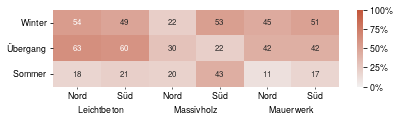

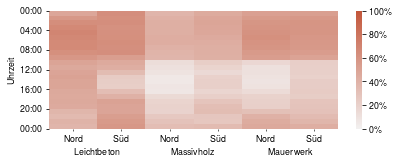

In [47]:
df = pp.getOccupied(PMV).loc[:, IDX[:,['N', 'S'],:,'pmv']].groupby(level=[0,1], axis=1).max().abs().lt(0.5)

fig, ax = plt.subplots(**style.size(aspect=0.3))
ax = sns.heatmap(data=df.groupby(tb.utils.getSeason(df.index)).mean().fillna(0).reindex(['Winter', 'Übergang', 'Sommer']).mul(100), vmin=0, vmax=100, cmap=style.Reds, annot=True, fmt='.2n',annot_kws={"size":8}, cbar_kws={'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(100, 0, symbol='%'))
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

fig, ax = plt.subplots(**style.size(aspect=0.4))
ax = sns.heatmap(data=df.groupby(df.index.hour).mean().fillna(0), cmap=style.Reds, vmin=0, vmax=1)
ax.set(title=None, ylabel='Uhrzeit', xlabel=None)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, 0, symbol='%'))
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax, 'y')
fig.tight_layout()

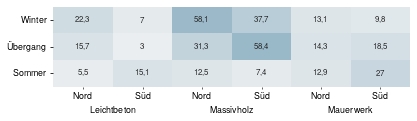

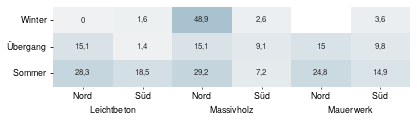

In [48]:
df = pp.getOccupied(PMV).loc[:, IDX[:,['N', 'S'],:,:]]
pmv = []
for (bui, app, room), group in df.groupby(level=[0,1,2], axis=1):
    group = group.stack([0,1,2]).reset_index()
    group = group.assign(comf = group['pmv'].abs().lt(0.5))
    pmv.append(group.groupby((group.comf != group.comf.shift()).cumsum()).agg({'bui':'first', 'app':'first', 'room': 'first', 'Datetime':['first', 'last', tb.utils.aggMINMAX], 'pmv': ['mean'], 'comf':['mean']}).set_axis(['bui', 'app', 'room', 'start','end', 'duration', 'pmv_mean', 'comfortable'], axis=1).where(lambda df: df.comfortable==0).dropna(how='all'))
pmv = pd.concat(pmv).reset_index(drop=True).assign(Season = lambda x: tb.utils.getSeason(x.start))
df = pmv.groupby(['bui', 'app', 'room', 'Season'])['duration'].agg(['mean']).apply(lambda x: x.dt.total_seconds()/60/60).unstack(['bui', 'app']).droplevel(0, axis=1)

fig, ax = plt.subplots(**style.size(aspect=0.3))
ax = sns.heatmap(data=df.loc['SZ'].round(1).reindex(['Winter', 'Übergang', 'Sommer']), cmap=style.Blues, annot=True, fmt='2n', vmin=0, vmax=120, cbar=None, annot_kws={"size":8}, cbar_kws=dict(label='$\si{\hour}$'))
ax.set(title=None, xlabel=None, ylabel=None)
cleanBuiAppAxis(ax)
fig.tight_layout()

fig, ax = plt.subplots(**style.size(aspect=0.3))
ax = sns.heatmap(data=df.loc['WZ'].round(1).reindex(['Winter', 'Übergang', 'Sommer']), cmap=style.Blues, annot=True, fmt='2n', vmin=0, vmax=120, cbar=None, annot_kws={"size":8}, cbar_kws=dict(label='$\si{\hour}$'))
ax.set(title=None, xlabel=None, ylabel=None)
cleanBuiAppAxis(ax)
fig.tight_layout()

# **Fensteröffnung**
___
[Zurück zum Anfang](#importe)

## Importiere Lüftungsdatensatz

In [49]:
L_stats = pp.getLüftungsStats()
L_stats = L_stats[L_stats.duration < pd.Timedelta(24, 'hours')]
L_stats = L_stats.assign(Season= lambda x: tb.utils.getSeason(x.idx_opening))
L_stats = L_stats.loc[IDX[:,['N', 'S'],:],:]

## Zusammenfassung

### absulte Häufigkeit der Fensteröffnung

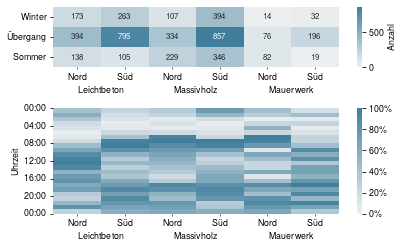

In [50]:
fig, axs = plt.subplots(2,1, **style.size(aspect=0.6), gridspec_kw=dict(height_ratios=[1,1.75]))
df = L_stats.reset_index().groupby(['bui', 'app', 'Season']).size().unstack(['bui', 'app']).reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(ax=axs[0], data=df, vmin=0, cmap=style.Blues, annot=True, fmt='3n',annot_kws={"size":8}, cbar_kws={'label':'Anzahl', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
df = L_stats['idx_opening'].dt.hour.reset_index().groupby(['bui', 'app', 'idx_opening']).size().unstack(['bui', 'app'])
ax = sns.heatmap(ax=axs[1], data=df.rank(axis=0, pct=True), cmap=style.Blues, vmin=0)
ax.set(title=None, ylabel='Tageszeit', xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, 0, symbol='%'))
fig.tight_layout()

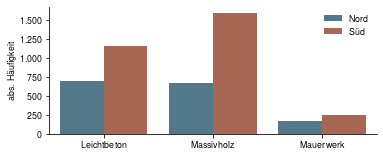

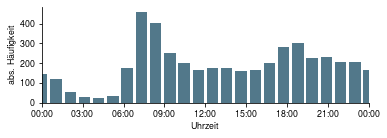

In [51]:
plt.figure(**style.size(aspect=0.4))
ax = sns.countplot(data=L_stats.rename(index=style.NAMES, columns=style.NAMES).reset_index(), x='bui', hue='app')
ax.set(title=None, ylabel='abs. Häufigkeit', xlabel=None)
ax.legend(title=None)
fig.tight_layout()

plt.figure(**style.size(aspect=0.3))
ax = sns.countplot(x=L_stats['idx_opening'].dt.hour, color = style.clrs[0])
ax.set(title=None, ylabel='abs. Häufigkeit', xlabel='Uhrzeit')
style.datemapaxis(ax, axis='x', steps=8)
fig.tight_layout()

## Anteil geöffneter Fenster (Gesamt)

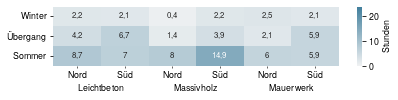

In [52]:
data = DB.loc[:,IDX[:,['N', 'S'],:,'Fenster']].gt(0).groupby(level=[0,1], axis=1).max()

fig, ax = plt.subplots(**style.size(aspect=0.25))
df = data.resample('D').sum()/60
ax = sns.heatmap(data=df.groupby(tb.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']).round(1), vmin=0, vmax=24, cmap=style.Blues, annot=True, fmt='2n',annot_kws={"size":8},cbar_kws={'label': 'Stunden', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

## Mittlere Dauer einer Lüftung
Bruacht [import](#importiere-lüftungsdatensatz) von `L_stats`

duration: 13% Outliner (IQR=-105.5, 194.5) entfernt


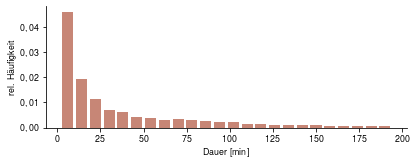

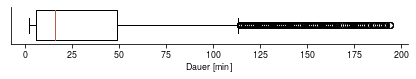

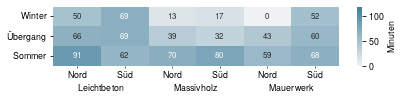

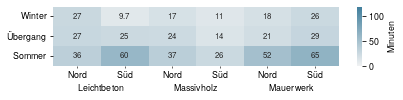

In [53]:
DurationOfOpening = L_stats.reset_index()[['bui', 'app','room', 'idx_opening', 'duration']]
DurationOfOpening['HoD'] = DurationOfOpening.idx_opening.dt.hour
DurationOfOpening['duration'] = DurationOfOpening.duration.dt.total_seconds().div(60)
DurationOfOpening = tb.utils.removeOutliner(DurationOfOpening.where(DurationOfOpening.duration > 0), col='duration')
DurationOfOpening['bins'] = pd.qcut(DurationOfOpening.duration, 3, labels=['short', 'medium', 'long'])

fig, ax = plt.subplots(**style.size(aspect=0.4))
sns.histplot(data=DurationOfOpening, x='duration', stat='density', color = style.clrs[1], shrink=.8, ec='None', bins=24)
ax.set(title=None, ylabel='rel. Häufigkeit', xlabel=r'Dauer $[\si{\min}]$')
fig.tight_layout()

fig, ax = plt.subplots(**style.size(aspect=0.2))
ax.boxplot(DurationOfOpening['duration'].dropna(), vert=False, widths=.8)
ax.set(yticklabels=[], xlabel=r'Dauer $[\si{\min}]$')
ax.yaxis.set_visible(False)
fig.tight_layout()

df = DurationOfOpening[DurationOfOpening.app != 'O'].assign(Season = lambda x: tb.utils.getSeason(x.idx_opening)).groupby(['bui', 'app', 'room', 'Season']).duration.mean().unstack([0,1])
for r, (room, _df) in enumerate(df.groupby('room')):
    fig, ax = plt.subplots(**style.size(aspect=0.25))
    ax = sns.heatmap(data=_df.droplevel(0).fillna(0).reindex(['Winter', 'Übergang', 'Sommer']), cmap=style.Blues, annot=True, vmin=0, vmax=120, annot_kws={"size":8}, cbar_kws=dict(aspect=12, label='Minuten'))
    ax.set(title=None, xlabel=None, ylabel=None)
    cleanBuiAppAxis(ax)
    fig.tight_layout()


Wenn $T_{amb, 24h} > 6°C$:
$$\mathrm{Fenster}[open, closed] = \begin{cases}
    \text{open if }& T_{air} >22°C, \\ 
    \text{closed if} & T_{air} < 18 °C, \\
    \text{closed if} & T_{amb} > (T_{air} + 3K), \\
    \text{closed otherwise.}
\end{cases}
$$


Wenn $T_{amb, 24h} > 6°C$:
$$\mathrm{Fenster}[open, closed] = \begin{cases}
    \text{open if }& T_{air} >25°C, \\ 
    \text{closed if} & T_{air} < 22 °C, \\
    \text{closed if} & T_{amb} > (T_{air} + 3K), \\
    \text{closed otherwise.}
\end{cases}
$$

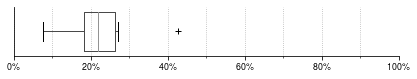

In [54]:
T_vent = DB.loc[:,IDX[:,:,['WZ', 'SZ'],['Tair', 'T_amb', 'Fenster']]].resample('H').mean().stack([0,1,2]).reset_index([1,2,3]).where(AMB.T_amb.resample('D').mean().resample('H').ffill() > 6).where(lambda df: (df.Tair > 22) & (df.T_amb < df.Tair + 3)).dropna(how='all')

fig, ax = plt.subplots(**style.size(aspect=0.2))
df = T_vent.set_index(['bui', 'app', 'room'], append=True).Fenster.gt(0).groupby(['bui', 'app']).value_counts(normalize=True).rename('n_open').unstack('Fenster')[True].to_frame()
df.boxplot(vert=False, widths=.8, sym='+')
ax.set_xlim(0,1)
ax.yaxis.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, is_latex=False, decimals=0))
ax.grid(which='both', axis='x', ls='dotted')
fig.tight_layout()

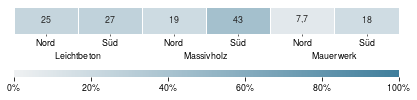

In [55]:
grid_kws = {"height_ratios": (8, 2)}
fig, (ax, cbar_ax) = plt.subplots(2,1, **style.size(aspect=.25), gridspec_kw=grid_kws)
ax = sns.heatmap(data=df[True].to_frame().T.mul(100), cmap=style.Blues, ax=ax, annot=True, fmt='.2n', vmin=0, vmax=100, cbar_ax=cbar_ax, linewidths=1, cbar_kws={"orientation": "horizontal"})
ax.set(title=None, ylabel=None, xlabel=None, yticklabels=[])
ax.yaxis.set_visible(False)
cbar = ax.collections[0].colorbar
cbar.ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(100, 0, symbol='%'))
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()